In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
tf = pd.read_csv('../../data/events.csv', low_memory=False)

In [ ]:
tf.columns

In [ ]:
tf['staticpage'].value_counts()

In [ ]:
tf['channel'].value_counts()

In [414]:
tf.head(10)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-05-29 13:29:26,visited site,0006a21a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Rio de Janeiro,Rio de Janeiro,Brazil,Smartphone,360x640,Android 5.1.1,Android 5.1
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-04-09 20:12:31,generic listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"10310,13333,13347,9902,9944,12774,12801,12744,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-04-09 20:12:31,visited site,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Rio de Janeiro,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome 65.0


In [ ]:
tf['campaign_source'].value_counts()

In [ ]:
tf['search_engine'].value_counts()

In [4]:
# to datetime:

tf['timestamp'] = pd.to_datetime(tf['timestamp'])

In [ ]:
comprados = tf.loc[tf['event'] == 'conversion']

# Agrego col con nombre del dia
comprados['weekday name'] = tf['timestamp'].dt.weekday_name

## Cantidad de compras por dia de la semana

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

comprados['weekday name'].value_counts().reindex(days).plot(kind='bar')

## Cantidad total de eventos por horario

In [ ]:
df_hr = tf.filter(items = ['country','timestamp', 'event'])

df_hr['hour'] = df_hr['timestamp'].dt.hour

gr = df_hr['hour'].value_counts(sort=False).plot(kind='line', figsize=(8, 5), grid=True, style="-o")
gr.set_xlabel('Hora (24hs)')
plt.xticks(range(0, 25));

# Analisis de Eventos:

## Cantidad de cada tipo de evento:

In [ ]:
# 5 predominantes:
eventos = tf['event'].value_counts()
eventos.head().plot(kind='bar')

In [ ]:
# Sacando evento 'viewed products':

tf['event'].loc[tf['event'] != 'viewed product'].value_counts().plot(kind='bar')

## Cantidad de eventos totales por pais

In [ ]:
# los 4 predominantes:
# el grafico es feo

df_short = tf.filter(items = ['event', 'country'])
df_short['country'].value_counts().head(4).plot(kind='bar')

## Cantidad de eventos 'viewed product' por mes

In [ ]:
df_event_vp = tf.loc[tf['event'] == 'viewed product' ]
g = df_event_vp.groupby([tf['timestamp'].dt.month, 'event']).size().unstack()\
                        .plot(kind='bar')
g.set_xlabel("Mes")
g.set_ylabel('Cantidad de eventos')
g.legend(['Viewed product'])

## cant ckeckouts >>> cant conversions:

In [ ]:
#mal grafico?
df_event = tf.filter(items = ['event', 'timestamp'])
checkout_vs_conv = df_event.loc[(tf['event'] == 'checkout') | (tf['event'] == 'conversion')]
checkout_vs_conv['event'].value_counts(normalize=True).plot(kind='barh')

## Modelos mas comprados:

In [ ]:
df_event_mod = tf.filter(items = ['event', 'model'])
df_event_mod.loc[df_event_mod['event'] == 'conversion']['model'].value_counts().head().plot(kind='bar')

## Cantidad de comprados por condicion del producto

In [ ]:
comprados = tf.loc[tf['event'] == 'conversion']

qual = ['Novo', 'Excelente', 'Muito Bom', 'Bom', 'Bom - Sem Touch ID']
comprados['condition'].value_counts().reindex(qual).plot(kind='barh')

In [ ]:
# Cantidad de productos (por 'condition') que tenemos en el dataset:

tf['condition'].value_counts().plot(kind='bar')

## Modelos no disponibles con más pedidos de notificación de stock 

In [ ]:
df_event_mod = tf.filter(items = ['event', 'model'])
df_event_mod.loc[df_event_mod['event'] == 'lead']['model'].value_counts().head().plot(kind='bar')

# 'new vs returning' por mes

In [ ]:
df_new_vs_ret = tf.filter(items = ['event', 'new_vs_returning'])
graf = tf.groupby([tf['timestamp'].dt.month, 'new_vs_returning']).size().unstack().plot(kind='bar')
graf.set(xlabel='Numero de mes', ylabel='Cantidad')
graf.legend(['New', 'Returning'])

# Cantidad de visitas por compra de cliente

## Solo los clientes que por lo menos realizaron una compra

In [288]:
person_event = tf.filter(items=['person', 'event'])
person_event['cant'] = 1
person_event = person_event.loc[(person_event['event'] == 'conversion') | (person_event['event'] == 'viewed product')]

person_conv = person_event.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
person_conv = person_conv.loc[(person_conv['cant']['conversion'].notnull()) & (person_conv['cant']['conversion'] != 0)]

In [289]:
# Cambio nombre columnas
person_conv.columns = ['conversion', 'viewed product']

In [290]:
person_conv.head()

,conversion,viewed product
person,,
00204059,1.0,44.0
00c13dee,1.0,17.0
00fdbb4b,1.0,3.0
0146a9df,1.0,23.0
01db2fe6,1.0,67.0


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

dx = sns.stripplot(x="conversion", y="viewed product", data=person_conv,\
                   jitter=True, linewidth=0.4, alpha=.4, marker=".", size=40, ax=ax)

dx.set(xlabel='Numero de compras', ylabel='Cantidad de visitas', \
       title='Relacion entre numero de compras y cantidad de visitas por usuario');


Cada punto es un cliente (identificado a partir de la columna 'person') que posee una cantidad total de visitas al sitio (cantidad de eventos 'viewed product') y un numero total de compras (cantidad de eventos 'conversion'). En el gráfico solo se muestran los usuarios que realizaron más de una compra.

In [ ]:
g = person_conv['conversion'].value_counts().plot(kind='bar')

g.set(xlabel="Numero de compras", ylabel='Cantidad', title='Cantidad total de compras')


In [ ]:
# los de 1 compra

person_conv1 = person_event.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
person_conv1 = person_conv1.loc[(person_conv1['cant']['conversion'].notnull()) & (person_conv1['cant']['conversion'] == 1)]

In [ ]:
person_conv1.columns = ['conversion', 'viewed product']
person_conv1.head()

In [ ]:
person_conv1['viewed product'].value_counts().head(10)

In [ ]:
#g = person_conv1['viewed product'].value_counts().plot().hist()
person_conv1.hist(column='viewed product', xlabelsize=15, bins=19)

- - -

# ¿Cuantos usuarios regresan 'x' cantidad de veces al sitio?

In [ ]:
# No hay registros de personas NaN
tf['person'].isna().sum()

In [ ]:
# Cantidad de usuarios distintos registrados
tf['person'].value_counts().count()

- - -

In [4]:
new_vs_returning = tf.filter(items=['person', 'new_vs_returning'])


# Podemos considerar que todos los valores nulos son registros de usuarios que regresan al sitio ('Returning').
# Luego descartaremos los usuarios que no tienen ningun registro de haber ingresado al sitio por primera vez ('New').

new_vs_returning.fillna({'new_vs_returning': 'Returning'}, inplace=True)

new_vs_returning = new_vs_returning.groupby(['person'])['new_vs_returning'].value_counts(dropna=False)

In [5]:
# Obtengo una serie
new_vs_returning.head()

person    new_vs_returning
0004b0a2  Returning            3
          New                  1
0006a21a  Returning            3
          New                  1
000a54b2  Returning           36
Name: new_vs_returning, dtype: int64

In [6]:
# Construyo un DataFrame
new_vs_returning_df = new_vs_returning.unstack()
new_vs_returning_df.head()

new_vs_returning,New,Returning
person,,
0004b0a2,1.0,3.0
0006a21a,1.0,3.0
000a54b2,1.0,36.0
00184bf9,1.0,50.0
0019c395,1.0,7.0


In [7]:
# Veo cuantos nulos hay en la columna 'New'. Es decir, cuantos usuarios no fueron detectados por primera vez
new_vs_returning_df['New'].value_counts(dropna=False)

 1.0    26898
NaN       726
Name: New, dtype: int64

In [8]:
# Veo cuantos nulos hay en la columna returning
new_vs_returning_df['Returning'].isna().sum()

0

In [9]:
# Elimino los usuarios que no fueron detectados por primera vez:
new_vs_returning_df.dropna(inplace=True)

[Text(0,0.5,'Cantidad de usuarios'),
 Text(0.5,0,'Numero de veces que regresa un usuario a la pagina'),
 Text(0.5,1,'Cuantos usuarios regresan "x" cantidad de veces al sitio')]

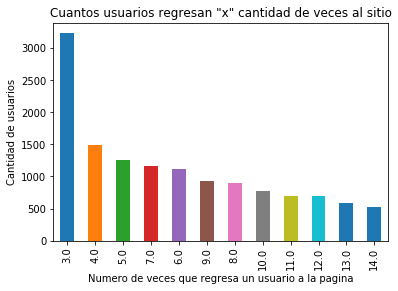

In [10]:
new_vs_returning_g = new_vs_returning_df['Returning'].value_counts().head(12).plot(kind='bar')

new_vs_returning_g.set(xlabel='Numero de veces que regresa un usuario a la pagina', ylabel='Cantidad de usuarios',\
                      title='Cuantos usuarios regresan "x" cantidad de veces al sitio')

---

In [3]:
new_vs_returning = tf.filter(items=['person', 'new_vs_returning'])


# Podemos considerar que todos los valores nulos son registros de usuarios que regresan al sitio ('Returning').
# Luego descartaremos los usuarios que no tienen ningun registro de haber ingresado al sitio por primera vez ('New').

new_vs_returning.fillna({'new_vs_returning': 'Returning'}, inplace=True)

new_vs_returning = new_vs_returning.groupby(['person'])['new_vs_returning'].value_counts(dropna=False)

In [6]:
# Obtengo una serie
new_vs_returning.head()

person    new_vs_returning
0004b0a2  Returning            3
          New                  1
0006a21a  Returning            3
          New                  1
000a54b2  Returning           36
Name: new_vs_returning, dtype: int64

In [4]:
# Construyo un DataFrame
new_vs_returning_df = new_vs_returning.unstack()
new_vs_returning_df.head()

new_vs_returning,New,Returning
person,,
0004b0a2,1.0,3.0
0006a21a,1.0,3.0
000a54b2,1.0,36.0
00184bf9,1.0,50.0
0019c395,1.0,7.0


In [271]:
# Veo cuantos nulos hay en la columna 'New'. Es decir, cuantos usuarios no fueron detectados por primera vez
new_vs_returning_df['New'].value_counts(dropna=False)

 1.0    26898
NaN       726
Name: New, dtype: int64

In [5]:
# Elimino los usuarios que no fueron detectados por primera vez:
new_vs_returning_df.dropna(inplace=True)

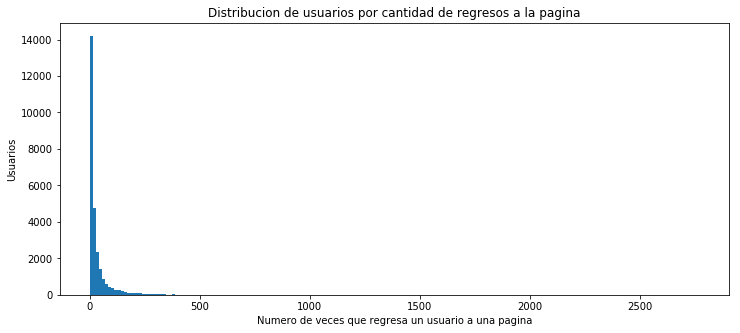

In [9]:
#Si tomamos Todos los valores registrados:

fig, ax = plt.subplots(figsize=(12, 5))

x = new_vs_returning_df['Returning']
g = ax.hist(x, bins=200);

plt.xlabel('Numero de veces que regresa un usuario a una pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

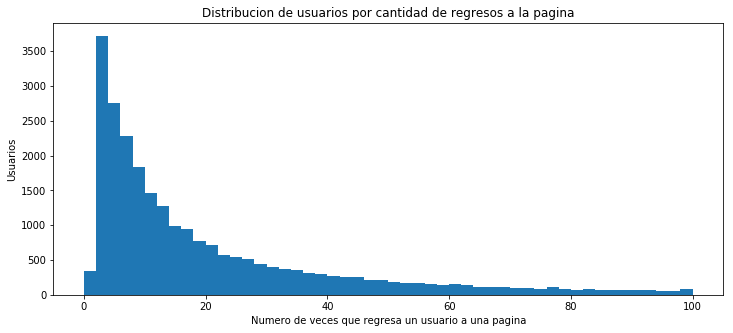

In [63]:
# Restringiendo los valores para una mejor visualizacion y mas especifica:

fig, axs = plt.subplots(figsize=(12, 5))

x = new_vs_returning_df['Returning']
axs.hist(x, bins=50, range=(0,100));

plt.xlabel('Numero de veces que regresa un usuario a una pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

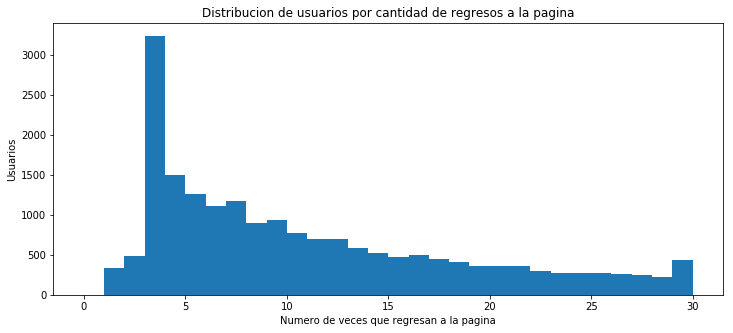

In [80]:
fig, axs = plt.subplots(figsize=(12, 5))

axs.hist(x, bins=30, range=(0,30), label='cfds');

plt.xlabel('Numero de veces que regresan a la pagina')
plt.ylabel('Usuarios')
plt.title('Distribucion de usuarios por cantidad de regresos a la pagina');

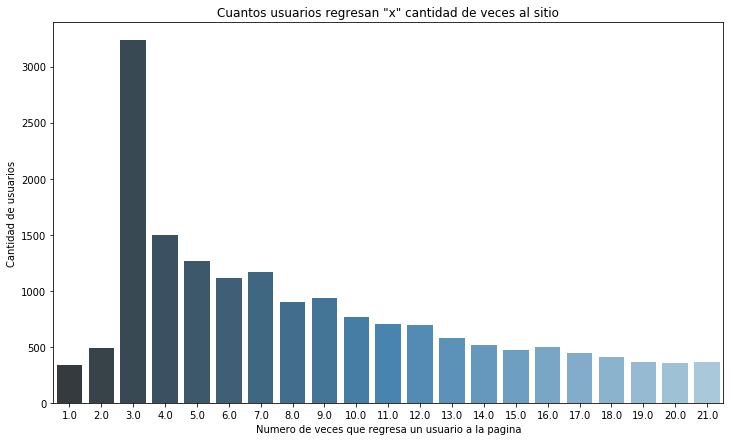

In [83]:
# Grafico de barras para ver detalladamente cuantas veces regresa al sitio la mayoria de los usuarios

fig, ax = plt.subplots(figsize=(12,7))

nums = range(1, 24)

relacion = new_vs_returning_df['Returning'].value_counts(sort=True).head(21)

g = sns.barplot(x=relacion.index, y=relacion.values, palette="Blues_d", orient='v', ax=ax)

g.set(xlabel='Numero de veces que regresa un usuario a la pagina', ylabel='Cantidad de usuarios',\
    title='Cuantos usuarios regresan "x" cantidad de veces al sitio');

# Diferencia entre primer y ultimo dia de entrada al sitio por usuario

In [294]:

sem_person = tf.filter(items=['person', 'timestamp', 'event'])
sem_person['cant'] = 1

sem_persongb = sem_person.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
sem_persongb = sem_persongb.loc[(sem_persongb['cant']['conversion'].notnull()) & (sem_persongb['cant']['conversion'] != 0)]

#sem_person['semana'] = sem_person['timestamp'].dt.week
#sem_person.drop_duplicates(subset='person', inplace=True)
#sem_person.head(10)
sem_persongb.head()

cant                                                    \
event    ad campaign hit brand listing checkout conversion generic listing   
person                                                                       
00204059             6.0          31.0      5.0        1.0             8.0   
00c13dee             2.0          47.0      6.0        1.0            14.0   
00fdbb4b             NaN           NaN      1.0        1.0             2.0   
0146a9df            19.0          16.0      2.0        1.0            15.0   
01db2fe6            48.0           3.0      5.0        1.0            10.0   

                                                                             \
event    lead search engine hit searched products staticpage viewed product   
person                                                                        
00204059  NaN               2.0               2.0        NaN           44.0   
00c13dee  NaN              10.0               NaN        1.0           17.0   
00fdbb4b  NaN               1.0               NaN        NaN            3.0   
0146a9df  NaN              13.0               1.0        NaN           23.0   
01db2fe6  1.0              20.0               6.0        3.0           67.0   

                       
event    visited site  
person                 
00204059         12.0  
00c13dee         10.0  
00fdbb4b          1.0  
0146a9df         11.0  
01db2fe6         28.0

In [148]:
cant_compras = tf.filter(items=['person', 'event'])
cant_compras['cant'] = 1
cant_compras = cant_compras.loc[(cant_compras['event'] == 'conversion')]

cant_compras = cant_compras.groupby(['person', 'event']).agg({'cant': 'sum'}).unstack()
cant_compras = cant_compras.loc[(cant_compras['cant']['conversion'].notnull()) & (cant_compras['cant']['conversion'] != 0)]

In [153]:
cant_compras.columns = ['conversion']
cant_compras.head()

,conversion
person,
00204059,1
00c13dee,1
00fdbb4b,1
0146a9df,1
01db2fe6,1


In [30]:
minimo = tf.groupby('person')['timestamp'].min()

In [31]:
maximo = tf.groupby('person')['timestamp'].max()

In [32]:
minimo.head()

person
0004b0a2   2018-05-31 23:38:05
0006a21a   2018-05-29 13:29:25
000a54b2   2018-04-09 20:12:31
00184bf9   2018-04-06 05:12:05
0019c395   2018-05-17 00:08:56
Name: timestamp, dtype: datetime64[ns]

In [33]:
minimo_df = minimo.to_frame()
minimo_df.head()

,timestamp
person,
0004b0a2,2018-05-31 23:38:05
0006a21a,2018-05-29 13:29:25
000a54b2,2018-04-09 20:12:31
00184bf9,2018-04-06 05:12:05
0019c395,2018-05-17 00:08:56


In [34]:
maximo_df = maximo.to_frame()
maximo_df.head()

,timestamp
person,
0004b0a2,2018-05-31 23:38:40
0006a21a,2018-05-29 13:29:35
000a54b2,2018-05-24 11:34:32
00184bf9,2018-05-17 04:45:15
0019c395,2018-05-17 00:11:26


In [35]:
max_min = pd.merge(maximo_df, minimo_df, on='person', how='outer')
max_min.columns = ['max', 'min']
max_min['diferencia'] = ((max_min['max']) - (max_min['min']))
max_min['dif en dias'] = max_min['diferencia'].dt.days
max_min.head(10)

,max,min,diferencia,dif en dias
person,,,,
0004b0a2,2018-05-31 23:38:40,2018-05-31 23:38:05,0 days 00:00:35,0
0006a21a,2018-05-29 13:29:35,2018-05-29 13:29:25,0 days 00:00:10,0
000a54b2,2018-05-24 11:34:32,2018-04-09 20:12:31,44 days 15:22:01,44
00184bf9,2018-05-17 04:45:15,2018-04-06 05:12:05,40 days 23:33:10,40
0019c395,2018-05-17 00:11:26,2018-05-17 00:08:56,0 days 00:02:30,0
001bb7eb,2018-06-08 12:19:50,2018-06-06 18:40:51,1 days 17:38:59,1
001f1653,2018-05-29 12:56:27,2018-05-29 12:56:08,0 days 00:00:19,0
00204059,2018-05-19 03:36:24,2018-01-18 00:19:28,121 days 03:16:56,121
0020f73c,2018-06-12 19:44:12,2018-06-12 19:44:12,0 days 00:00:00,0


In [18]:
# Ahora busco la cantidad total de veces (en dias) que entro cada usuario a la pagina

dias_person = tf.filter(items=['person', 'timestamp'])
dias_person['dia'] = dias_person['timestamp'].dt.dayofyear
dias_person.head(10)

,person,timestamp,dia
0,0004b0a2,2018-05-31 23:38:05,151
1,0004b0a2,2018-05-31 23:38:05,151
2,0004b0a2,2018-05-31 23:38:09,151
3,0004b0a2,2018-05-31 23:38:40,151
4,0006a21a,2018-05-29 13:29:25,149
5,0006a21a,2018-05-29 13:29:26,149
6,0006a21a,2018-05-29 13:29:27,149
7,0006a21a,2018-05-29 13:29:35,149
8,000a54b2,2018-04-09 20:12:31,99
9,000a54b2,2018-04-09 20:12:31,99


In [28]:
# Cantidad de dias distintos que cada usuario entro a la pagina:
cant_dias_person = dias_person.groupby('person')['dia'].nunique()
cant_dias_person.head(10)

person
0004b0a2     1
0006a21a     1
000a54b2     2
00184bf9     3
0019c395     1
001bb7eb     2
001f1653     1
00204059    11
0020f73c     1
0024a82b     1
Name: dia, dtype: int64

In [29]:
cant_dias_person_df = cant_dias_person.to_frame()
cant_dias_person_df.columns = ['cantidad de dias distintos']
cant_dias_person_df.head(10)

,cantidad de dias distintos
person,
0004b0a2,1
0006a21a,1
000a54b2,2
00184bf9,3
0019c395,1
001bb7eb,2
001f1653,1
00204059,11
0020f73c,1


In [36]:
diferencia_y_cantidad = pd.merge(cant_dias_person_df, max_min, on='person', how='outer')
diferencia_y_cantidad.head()

,cantidad de dias distintos,max,min,diferencia,dif en dias
person,,,,,
0004b0a2,1,2018-05-31 23:38:40,2018-05-31 23:38:05,0 days 00:00:35,0
0006a21a,1,2018-05-29 13:29:35,2018-05-29 13:29:25,0 days 00:00:10,0
000a54b2,2,2018-05-24 11:34:32,2018-04-09 20:12:31,44 days 15:22:01,44
00184bf9,3,2018-05-17 04:45:15,2018-04-06 05:12:05,40 days 23:33:10,40
0019c395,1,2018-05-17 00:11:26,2018-05-17 00:08:56,0 days 00:02:30,0


In [38]:
# No hay nulos:
diferencia_y_cantidad.isna().sum()

cantidad de dias distintos    0
max                           0
min                           0
diferencia                    0
dif en dias                   0
dtype: int64

In [159]:
diferencia_y_cantidad_filter = diferencia_y_cantidad.filter(items = ['cantidad de dias distintos', 'dif en dias'])
diferencia_y_cantidad_filter.head(12)

,cantidad de dias distintos,dif en dias
person,,
0004b0a2,1,0
0006a21a,1,0
000a54b2,2,44
00184bf9,3,40
0019c395,1,0
001bb7eb,2,1
001f1653,1,0
00204059,11,121
0020f73c,1,0


In [157]:
cant_compras_y_dias = pd.merge(diferencia_y_cantidad_filter, cant_compras, on='person', how='inner')

In [158]:
cant_compras_y_dias.head()

,cantidad de dias distintos,dif en dias,conversion
person,,,
00204059,11,121,1
00c13dee,7,66,1
00fdbb4b,2,0,1
0146a9df,9,86,1
01db2fe6,20,103,1


# ¿Qué campaña de marketing se puede considerar mas "eficiente"?

## ¿Qué porcentaje de los usuarios que entra al sitio a traves de una campaña compran uno o más productos?

In [5]:
persons_campaign_event = tf.filter(items=['person', 'event', 'campaign_source'])

person_campaigns = persons_campaign_event.groupby(['person'])['campaign_source'].value_counts()
person_events = persons_campaign_event.groupby(['person'])['event'].value_counts()

In [486]:
person_campaigns.head()

person    campaign_source
0004b0a2  criteo             1
0006a21a  criteo             1
000a54b2  google             2
0019c395  google             2
001bb7eb  google             1
Name: campaign_source, dtype: int64

In [487]:
person_events.head(15)

person    event            
0004b0a2  ad campaign hit       1
          checkout              1
          viewed product        1
          visited site          1
0006a21a  ad campaign hit       1
          checkout              1
          viewed product        1
          visited site          1
000a54b2  viewed product       19
          brand listing         6
          generic listing       5
          ad campaign hit       2
          search engine hit     2
          visited site          2
          checkout              1
Name: event, dtype: int64

In [6]:
# Creacion de Dataframe de eventos y personas
person_events_df = person_events.to_frame()
person_events_df.columns = ['cantidad evento']
person_events_df.reset_index(inplace=True)
person_events_df.set_index('person', inplace=True)
person_events_df.head()

,event,cantidad evento
person,,
0004b0a2,ad campaign hit,1
0004b0a2,checkout,1
0004b0a2,viewed product,1
0004b0a2,visited site,1
0006a21a,ad campaign hit,1


In [7]:
# Filtro los que tienen compras:
person_events_df = person_events_df.loc[person_events_df['event'] == 'conversion']

In [8]:
person_campaigns_df = person_campaigns.to_frame()

person_campaigns_df.columns = ['cantidad ingresos']
person_campaigns_df.reset_index(inplace=True)
person_campaigns_df.set_index('person', inplace=True)

person_campaigns_df.head()

,campaign_source,cantidad ingresos
person,,
0004b0a2,criteo,1
0006a21a,criteo,1
000a54b2,google,2
0019c395,google,2
001bb7eb,google,1


In [9]:
# Hago un join: dejo a los usuarios que tienen compras

campaing_conversion = pd.merge(person_campaigns_df, person_events_df, on='person', how='right')
campaing_conversion.head()

,campaign_source,cantidad ingresos,event,cantidad evento
person,,,,
00204059,zanox,4.0,conversion,1
00204059,FacebookAds,1.0,conversion,1
00204059,google,1.0,conversion,1
00c13dee,google,1.0,conversion,1
00c13dee,zanox,1.0,conversion,1


In [10]:
compras_por_campaing = campaing_conversion.groupby('campaign_source')['event'].value_counts()

In [11]:
compras_por_campaing_df = compras_por_campaing.to_frame()
compras_por_campaing_df.columns = ['cantidad compradores']
compras_por_campaing_df.reset_index(inplace=True)
compras_por_campaing_df = compras_por_campaing_df.filter(items =['campaign_source', 'cantidad compradores'])
compras_por_campaing_df.head()

,campaign_source,cantidad compradores
0,Facebook,5
1,FacebookAds,28
2,FacebookSocial,1
3,afilio,30
4,bing,28


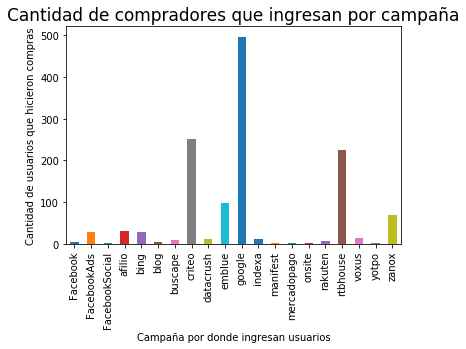

In [12]:
compras_por_campaing_df.plot(kind='bar', x='campaign_source', y='cantidad compradores', legend=False)
plt.ylabel('Cantidad de usuarios que hicieron compras', fontsize=10)
plt.xlabel('Campaña por donde ingresan usuarios')
plt.title('Cantidad de compradores que ingresan por campaña', fontsize=17);

Se podria ver el porcentaje de estos numeros con respecto al total de usuarios por campaña para poder hacer una mejor comparacion.

A la hora de la comparacion tambien se debe tener en cuenta la cantidad total de usuarios que ingresan al sitio por campaña, lo cual ya ha sido analizado anteriormente.

In [13]:
# Busco la cantidad total de usuarios que entraron al sitio por cada campaña al menos una vez

person_campaign =tf.filter(items=['person', 'event', 'campaign_source']).loc[tf['event'] == 'ad campaign hit']
person_campaign = person_campaign.drop_duplicates()
person_campaign.head()

,person,event,campaign_source
0,0004b0a2,ad campaign hit,criteo
6,0006a21a,ad campaign hit,criteo
11,000a54b2,ad campaign hit,google
99,0019c395,ad campaign hit,google
107,001bb7eb,ad campaign hit,google


In [14]:
person_campaign_count = person_campaign.groupby('person')['campaign_source'].value_counts()
person_campaign_count_df = person_campaign_count.to_frame()
person_campaign_count_df.columns = ['cant']
person_campaign_count_df.reset_index(inplace=True)
person_campaign_count_df.set_index('person', inplace=True)
person_campaign_count_df.head()

,campaign_source,cant
person,,
0004b0a2,criteo,1
0006a21a,criteo,1
000a54b2,google,1
0019c395,google,1
001bb7eb,google,1


In [15]:
cantidad_persons_campaign = person_campaign_count_df['campaign_source'].value_counts().to_frame()
cantidad_persons_campaign.columns = ['cantidad total']
cantidad_persons_campaign.reset_index(inplace=True)
cantidad_persons_campaign.columns = ['campaign_source', 'cantidad total']
cantidad_persons_campaign.set_index('campaign_source', inplace=True)
cantidad_persons_campaign.head()

,cantidad total
campaign_source,
google,17372
criteo,4672
rtbhouse,2241
zanox,572
FacebookAds,407


In [16]:
# Hago un join:
# Obtengo la cantidad de usuarios que entraron al sitio por campaña y la cantidad de los usuarios que alguna vez compraron 

# Filtro solo los primeros 10 con mayor cantidad total de usuarios para una mejor comparacion y no ver datos irrelevantes

campaign_total_vs_compras = pd.merge(cantidad_persons_campaign.head(10), compras_por_campaing_df, on='campaign_source', how='left')
campaign_total_vs_compras['porcentaje'] = (campaign_total_vs_compras['cantidad compradores'] / campaign_total_vs_compras['cantidad total']) * 100
campaign_total_vs_compras


,campaign_source,cantidad total,cantidad compradores,porcentaje
0,google,17372,497,2.860926
1,criteo,4672,251,5.372432
2,rtbhouse,2241,224,9.995538
3,zanox,572,69,12.062937
4,FacebookAds,407,28,6.879607
5,emblue,384,97,25.260417
6,voxus,344,14,4.069767
7,afilio,272,30,11.029412
8,bing,228,28,12.280702
9,rakuten,97,6,6.185567


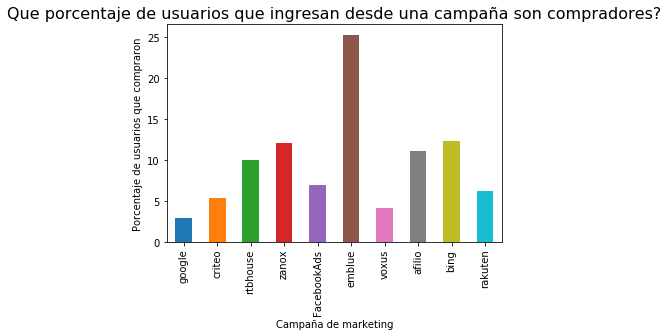

In [17]:
campaign_total_vs_compras.plot(kind='bar', x='campaign_source', y='porcentaje', legend=False)\
                    .set(ylabel='Porcentaje de usuarios que compraron',\
                    xlabel='Campaña de marketing')

plt.title('Que porcentaje de usuarios que ingresan desde una campaña son compradores?', fontsize=16);

Los datos que parecen mas ser relevantes son los siguientes:
    - Campaña 'emblue' con un 25.26 porciento de compradores (97 de 348)
    - Campaña 'bing' con un 12.28 porciento de compradores (28 de 228)
    - Campaña 'zanox' con un 12.0 porciento de compradores (69 de 572)
    - Campaña 'rtbhouse' con un 9.99 porciento de compradores (224 de 2241)
    - Campaña 'google' con un 2.86 porciento de compradores (497 de 17372)
    

Cabe destacar que, a pesar de que la campaña de marketing de 'google' en este grafico es la de menos porcentaje de compradores, es la campaña en la cual se registró la mayor cantidad de compradores (497) y mayor trafico de usuarios (17372 usuarios distintos).

La campaña de marketing de 'emblue' es la que más se destaca del resto. Es la sexta campaña con más usuarios que cliquearon (348) y la que mejor porcentaje de compradores tiene (25.26%. Es decir: 97 de 348), siendo la cuarta con mas cantidad de compradotes.

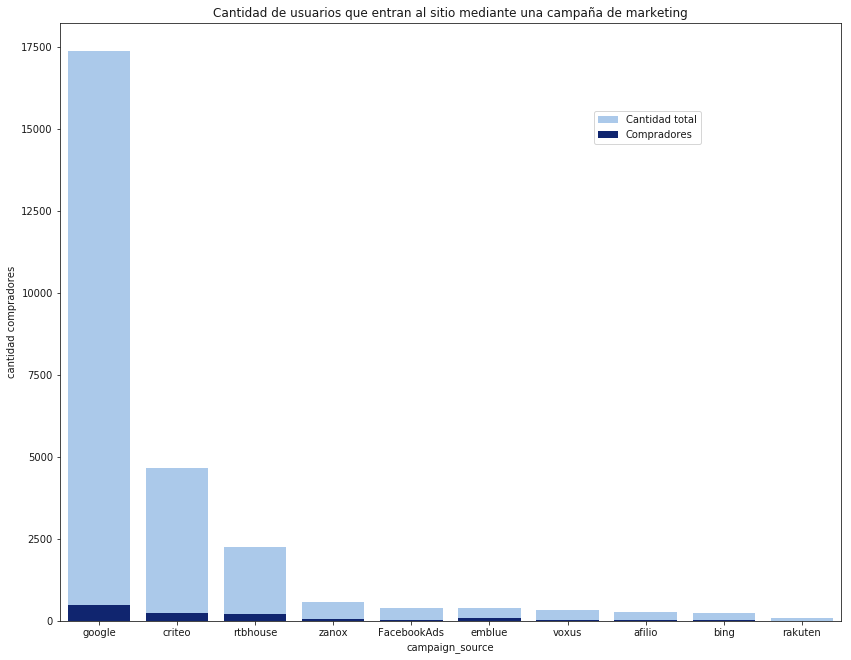

In [63]:
# Otro grafico para mejor comparacion:

ax = plt.figure(figsize = (14, 11))

sns.set_color_codes('pastel')
sns.barplot(data = campaign_total_vs_compras, x = 'campaign_source', y = 'cantidad total', label = 'Cantidad total', color = 'b')\
            .set_title('Cantidad de usuarios que entran al sitio mediante una campaña de marketing')

sns.set_color_codes('dark')
sns.barplot(data = campaign_total_vs_compras, x = 'campaign_source', y = 'cantidad compradores', label = 'Compradores', color = 'b')

ax.legend(ncol=1, bbox_to_anchor=(0.7, 0.7), frameon=True);

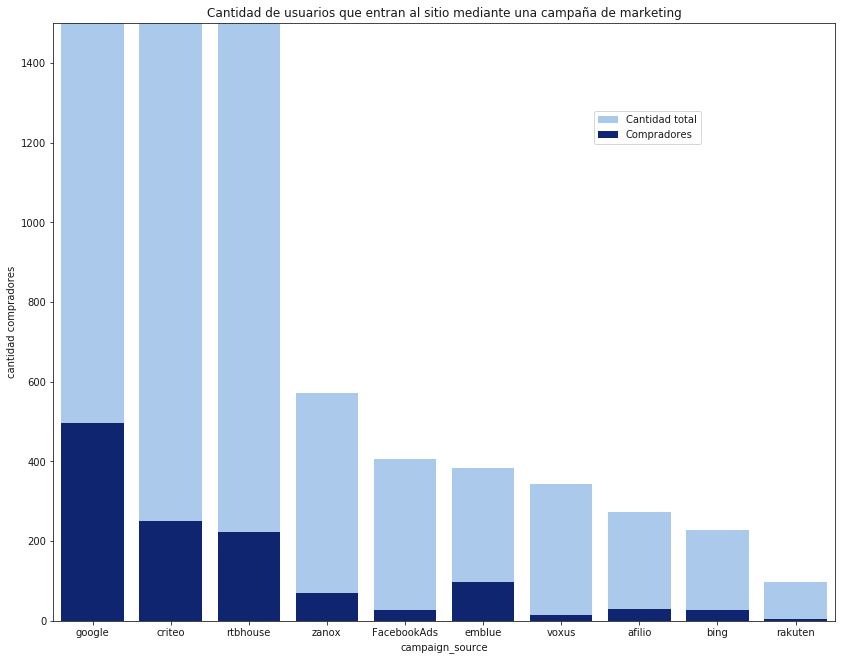

In [64]:
# Haciendo zoom para ver mejor las comparaciones entre campañas con menos usuarios

ax = plt.figure(figsize = (14, 11))

sns.set_color_codes('pastel')

g1 = sns.barplot(data = campaign_total_vs_compras, x = 'campaign_source', y = 'cantidad total', label = 'Cantidad total',\
            color = 'b')\
            .set_title('Cantidad de usuarios que entran al sitio mediante una campaña de marketing')


sns.set_color_codes('dark')

g2 = sns.barplot(data = campaign_total_vs_compras, x = 'campaign_source', y = 'cantidad compradores',\
            label = 'Compradores', color = 'b')

g2.set_ylim(0,1500)

ax.legend(ncol=1, bbox_to_anchor=(0.7, 0.7), frameon=True);


# Modelos más comprados por usuarios que cliquearon una determinada campaign

In [87]:
persons_conversion_model = tf.filter(items=['person', 'event', 'model'])

persons_conversion_model = persons_conversion_model.loc[persons_conversion_model['event'] == 'conversion']\
                            .groupby(['person'])['model'].value_counts()

persons_conversion_model_df = persons_conversion_model.to_frame()
persons_conversion_model_df.columns = ['cantidad compras']
persons_conversion_model_df.reset_index(inplace=True)
#persons_conversion_model_df.set_index('person', inplace=True)

In [94]:
# Selecciono el mas comprado por cada persona
persons_conversion_model_df = persons_conversion_model_df.sort_values('cantidad compras', ascending=False).drop_duplicates('person')

In [95]:
persons_conversion_model_df.head()

,person,model,cantidad compras
622,ba325a6b,Samsung Galaxy S6 Flat,10
575,a96e304b,iPhone 5c,8
225,4200bdee,Samsung Galaxy S6 Flat,8
827,f646efa2,Samsung Galaxy J5,8
698,d12fbe38,Samsung Galaxy Note 4,8


In [105]:
# Join: Los usuarios que alguna vez entraron al sitio por una campaña y ademas hicieron una o mas compras

model_campaign = pd.merge(person_campaign_count_df, persons_conversion_model_df, on='person', how='inner')
model_campaign.head(10)

,person,campaign_source,cant,model,cantidad compras
0,00204059,FacebookAds,1,Motorola Moto X2,1
1,00204059,google,1,Motorola Moto X2,1
2,00204059,zanox,1,Motorola Moto X2,1
3,00c13dee,google,1,Samsung Galaxy Core Plus Duos TV,1
4,00c13dee,zanox,1,Samsung Galaxy Core Plus Duos TV,1
5,0146a9df,criteo,1,iPhone 5s,1
6,0146a9df,google,1,iPhone 5s,1
7,0146a9df,rtbhouse,1,iPhone 5s,1
8,01db2fe6,FacebookAds,1,Samsung Galaxy J5,1
9,01db2fe6,FacebookSocial,1,Samsung Galaxy J5,1


In [121]:
d = model_campaign.groupby('campaign_source')['model'].value_counts().to_frame()

d.columns = ['cant']
d.reset_index(inplace=True)

d.head()

,campaign_source,model,cant
0,Facebook,Samsung Galaxy J5,2
1,Facebook,LG K10 Novo,1
2,Facebook,Motorola Moto G4 Plus,1
3,Facebook,iPhone 6,1
4,FacebookAds,iPhone 6,5


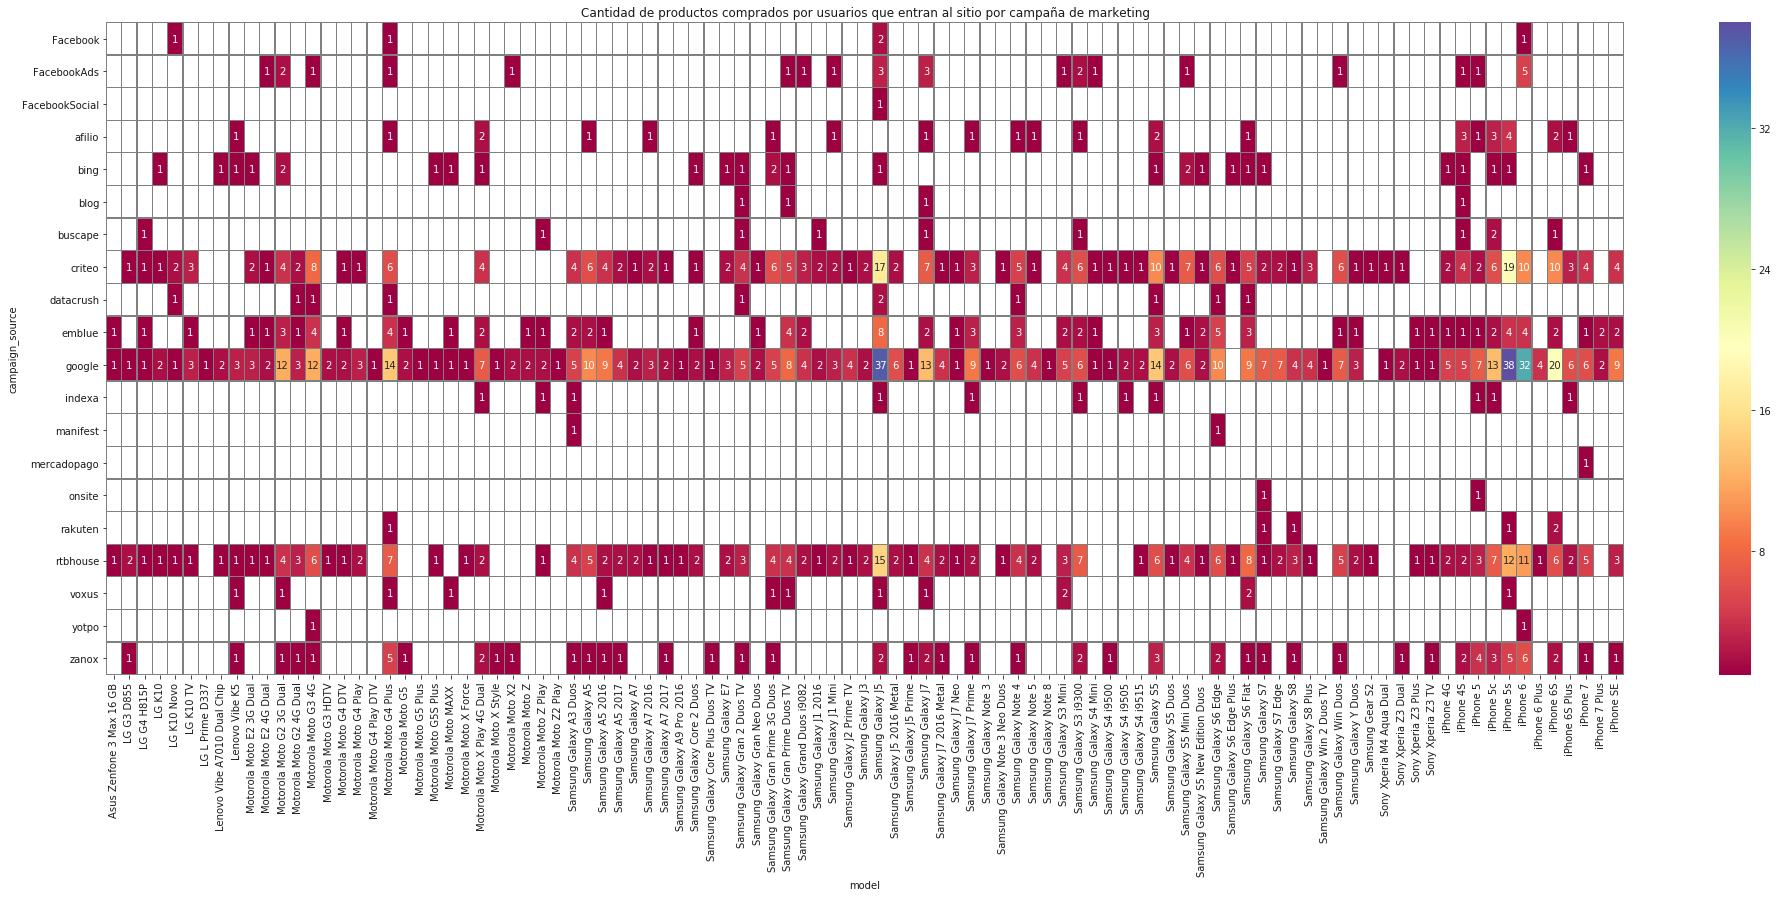

In [221]:
pivot = d.pivot(index='campaign_source', columns='model', values='cant')

ax = plt.figure(figsize = (34, 12))

g = sns.heatmap(pivot, annot=True, linewidths=0.3, cmap='Spectral', linecolor='grey')

plt.title('Cantidad de productos comprados por usuarios que entran al sitio por campaña de marketing');

In [178]:
# Restringiendo a las campañas mas relevantes:

In [208]:
top3_campaigns = person_campaign_count_df['campaign_source'].value_counts().head(3).index

In [209]:
person_campaign_count_df_r = person_campaign_count_df.loc[person_campaign_count_df['campaign_source'].isin(top3_campaigns)]

In [210]:
# Join: Los usuarios que alguna vez entraron al sitio por una campaña y ademas hicieron una o mas compras

model_campaign_r = pd.merge(person_campaign_count_df_r, persons_conversion_model_df, on='person', how='inner')
model_campaign_r.head()

,person,campaign_source,cant,model,cantidad compras
0,00204059,google,1,Motorola Moto X2,1
1,00c13dee,google,1,Samsung Galaxy Core Plus Duos TV,1
2,0146a9df,criteo,1,iPhone 5s,1
3,0146a9df,google,1,iPhone 5s,1
4,0146a9df,rtbhouse,1,iPhone 5s,1


In [211]:
model_campaign_r['campaign_source'].value_counts()

google      497
criteo      251
rtbhouse    224
Name: campaign_source, dtype: int64

In [212]:
d2 = model_campaign_r.groupby('campaign_source')['model'].value_counts().to_frame()

d2.columns = ['cant']
d2.reset_index(inplace=True)

In [227]:
pivot = d2.pivot(index='model', columns='campaign_source', values='cant')

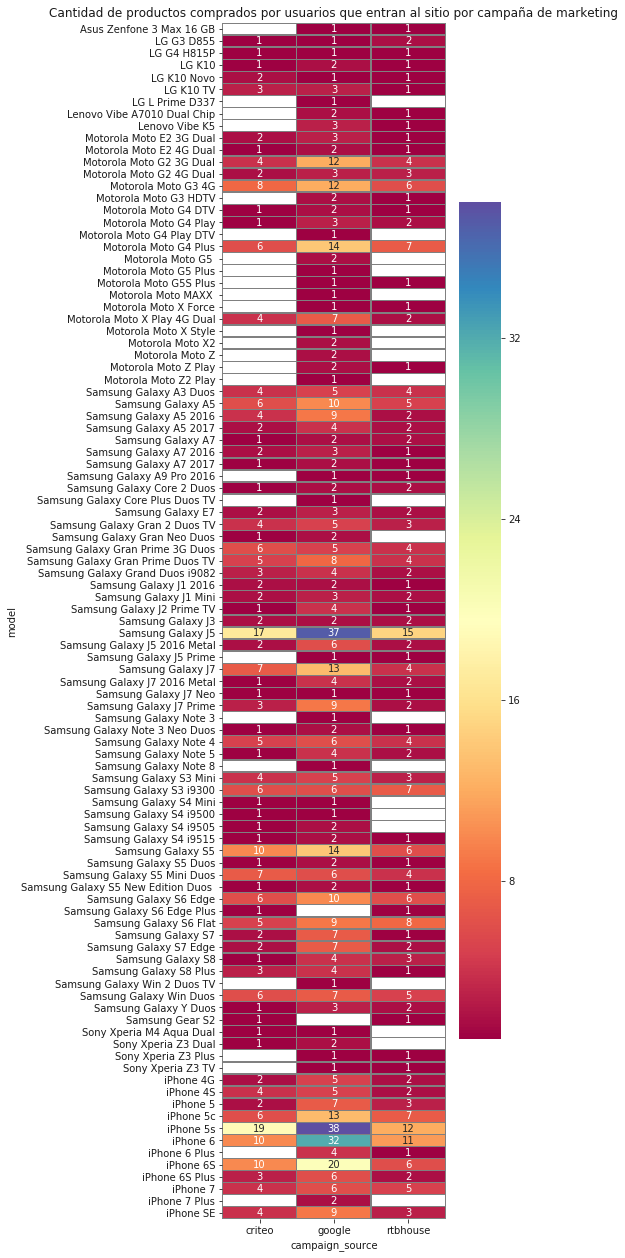

In [228]:
ax = plt.figure(figsize = (5, 22))

g = sns.heatmap(pivot, annot=True, linewidths=0.3, cmap='Spectral', linecolor='grey')

plt.title('Cantidad de productos comprados por usuarios que entran al sitio por campaña de marketing');

In [229]:
# Que queda mejor??

In [238]:
pivot2 = d2.pivot(index='campaign_source', columns='model', values='cant')

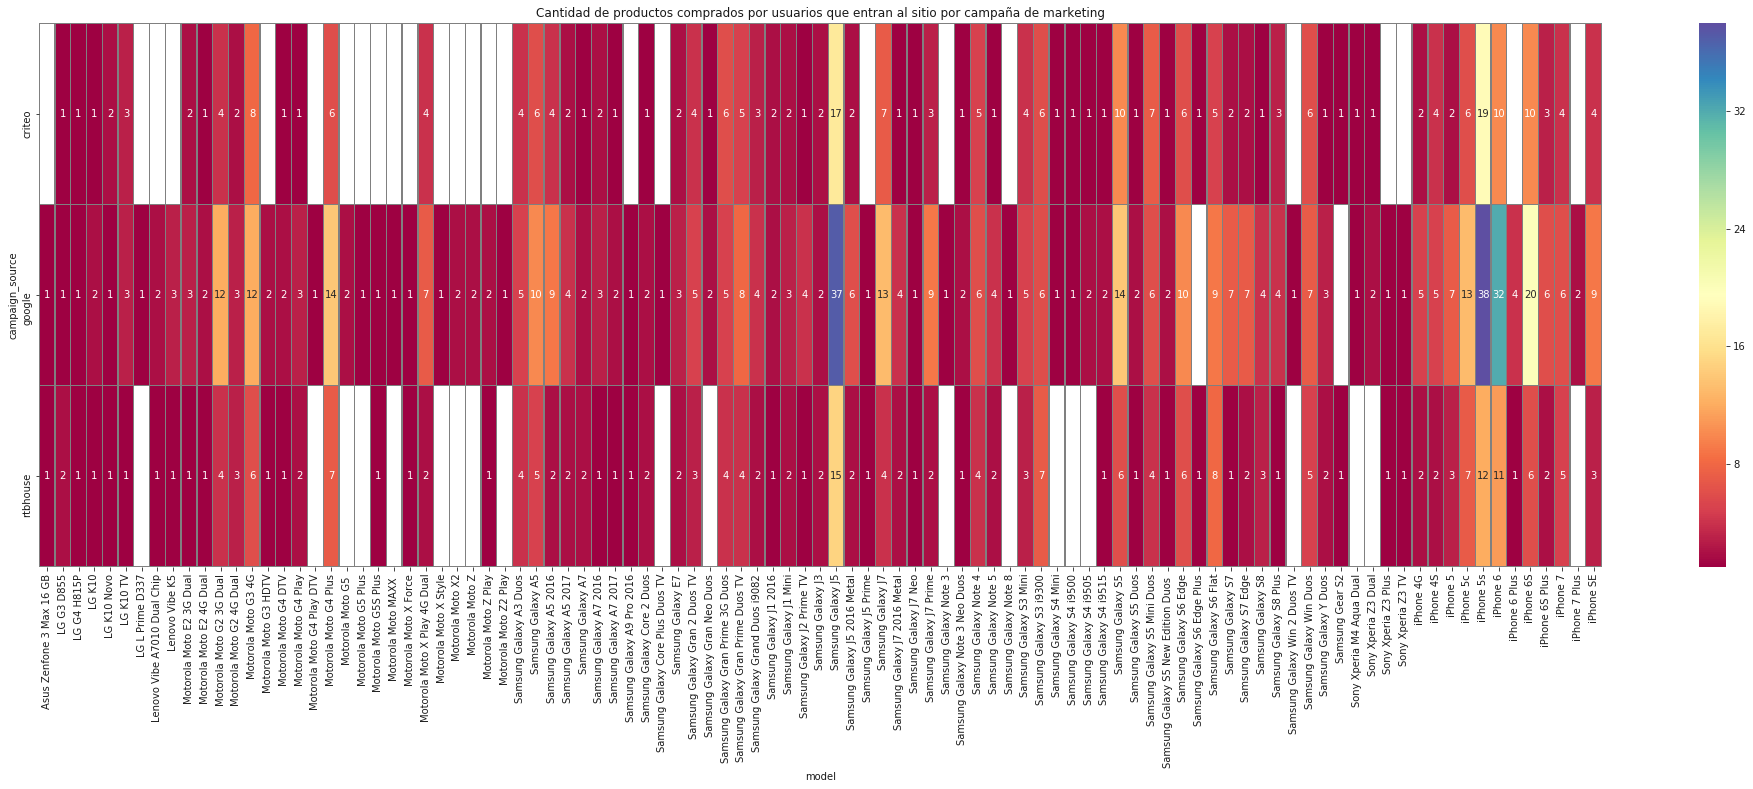

In [225]:
ax = plt.figure(figsize = (35, 10))

g = sns.heatmap(pivot2, annot=True, linewidths=0.3, cmap='Spectral', linecolor='grey')

plt.title('Cantidad de productos comprados por usuarios que entran al sitio por campaña de marketing');

In [ ]:
 # Podemos ver solo los productos que estan en todas las filas::

In [242]:
pivot2.dropna(axis='columns', inplace=True)

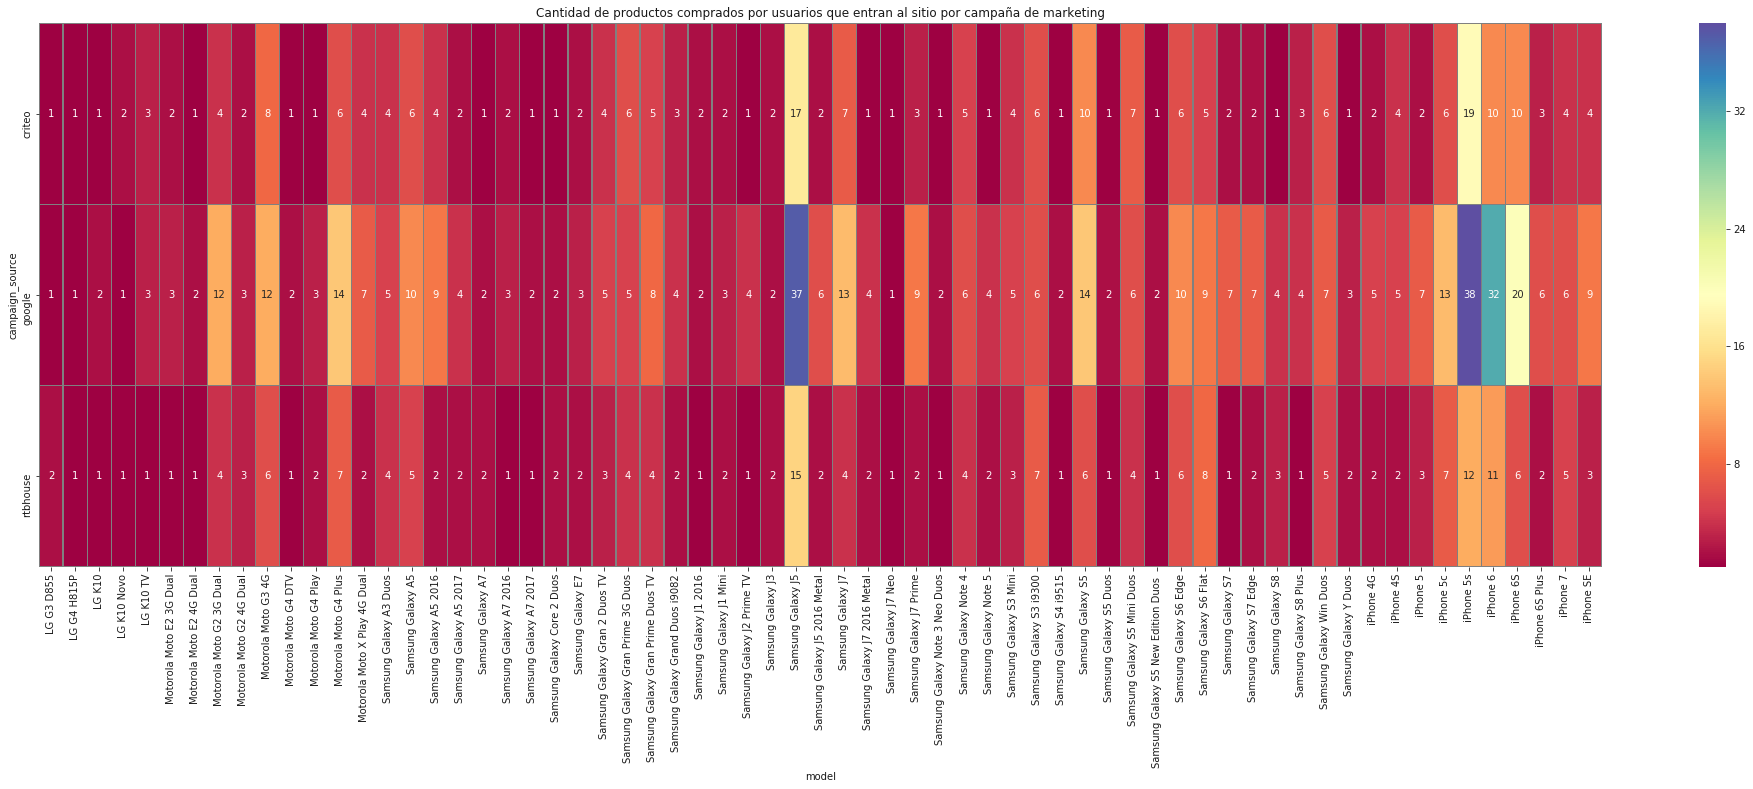

In [243]:
ax = plt.figure(figsize = (35, 10))

g = sns.heatmap(pivot2, annot=True, linewidths=0.3, cmap='Spectral', linecolor='grey')

plt.title('Cantidad de productos comprados por usuarios que entran al sitio por campaña de marketing');

No es posible destacar un comportamiento de usuarios haciendo una division por campaña. 
Más allá de la diferencia de cantidades de compradores entre campañas, la tendencia a comprar determinados productos, en general, es la misma. Por esto no se puede decir que los usuarios que entran al sitio por una campaña especifica tienen distinto comportamiento a los usuarios que entran en otras campañas (respecto a las compras de los diferentes productos).

Esto puede relacionarse con el grafico de tiempo que muestra las compras y las entradas por distintas campañas.

 # Cantidad de regresos vs diferencia entre primer y ultimo dia de conexion al sitio de cada usuario

In [1]:
primer_dia = tf.groupby('person')['timestamp'].min()
ultimo_dia = tf.groupby('person')['timestamp'].max()

NameError: name 'tf' is not defined

In [9]:
primer_dia_df = primer_dia.to_frame()
primer_dia_df.head()

,timestamp
person,
0004b0a2,2018-05-31 23:38:05
0006a21a,2018-05-29 13:29:25
000a54b2,2018-04-09 20:12:31
00184bf9,2018-04-06 05:12:05
0019c395,2018-05-17 00:08:56


In [10]:
ultimo_dia_df = ultimo_dia.to_frame()
ultimo_dia_df.head()

,timestamp
person,
0004b0a2,2018-05-31 23:38:40
0006a21a,2018-05-29 13:29:35
000a54b2,2018-05-24 11:34:32
00184bf9,2018-05-17 04:45:15
0019c395,2018-05-17 00:11:26


In [11]:
dif_dias_df = pd.merge(ultimo_dia_df, primer_dia_df, on='person', how='outer')
dif_dias_df.columns = ['primer', 'ultimo']
dif_dias_df['diferencia'] = ((dif_dias_df['primer']) - (dif_dias_df['ultimo']))
dif_dias_df['dif en dias'] = dif_dias_df['diferencia'].dt.days
dif_dias_df.head()

,primer,ultimo,diferencia,dif en dias
person,,,,
0004b0a2,2018-05-31 23:38:40,2018-05-31 23:38:05,0 days 00:00:35,0
0006a21a,2018-05-29 13:29:35,2018-05-29 13:29:25,0 days 00:00:10,0
000a54b2,2018-05-24 11:34:32,2018-04-09 20:12:31,44 days 15:22:01,44
00184bf9,2018-05-17 04:45:15,2018-04-06 05:12:05,40 days 23:33:10,40
0019c395,2018-05-17 00:11:26,2018-05-17 00:08:56,0 days 00:02:30,0


In [14]:
dif_dias_df[['dif en dias']].head()

,dif en dias
person,
0004b0a2,0
0006a21a,0
000a54b2,44
00184bf9,40
0019c395,0


In [15]:
# Tomando el dataframe creado anteriormente de la cantidad de regresos de cada usuario:
new_vs_returning_df.head()

new_vs_returning,New,Returning
person,,
0004b0a2,1.0,3.0
0006a21a,1.0,3.0
000a54b2,1.0,36.0
00184bf9,1.0,50.0
0019c395,1.0,7.0


In [12]:
cant_regresos_vs_dif_dias = pd.merge(dif_dias_df[['dif en dias']], new_vs_returning_df[['Returning']], on='person', how='right')
cant_regresos_vs_dif_dias.head()

,dif en dias,Returning
person,,
0004b0a2,0,3.0
0006a21a,0,3.0
000a54b2,44,36.0
00184bf9,40,50.0
0019c395,0,7.0


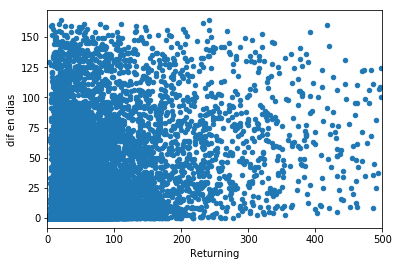

In [105]:
#.loc[cant_regresos_vs_dif_dias['Returning'] < 500]
cant_regresos_vs_dif_dias.plot(kind='scatter', y='dif en dias', x='Returning', xlim=(0,500))

/home/seba/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


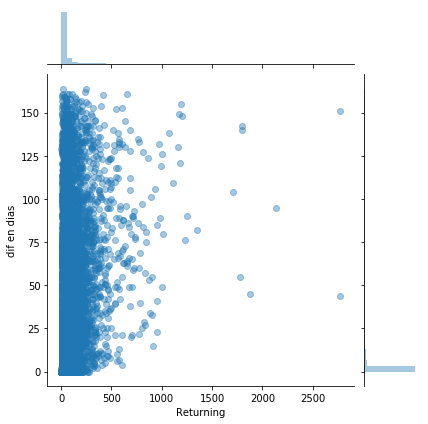

In [107]:
#x = cant_regresos_vs_dif_dias['Returning'].loc[cant_regresos_vs_dif_dias['Returning'] < 500]
#y = cant_regresos_vs_dif_dias['dif en dias']

g = sns.jointplot("Returning", "dif en dias", data=cant_regresos_vs_dif_dias, alpha=0.4)

/home/seba/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'cdsa')

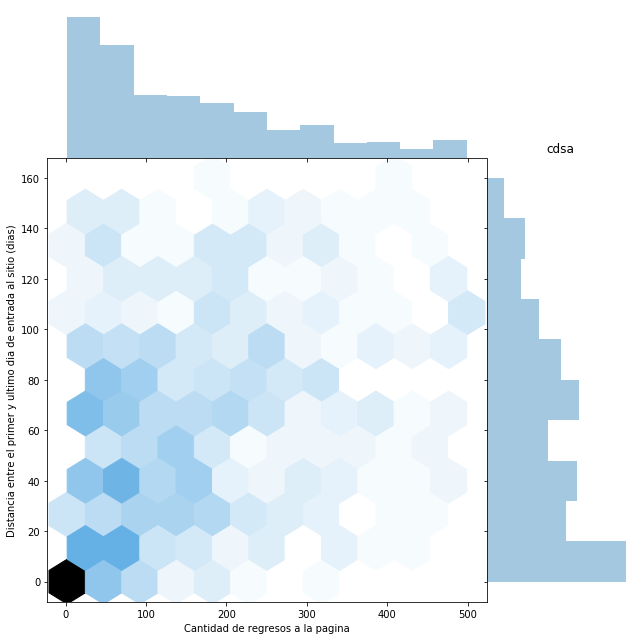

In [97]:
# Restringiendo a solo los compradores:

mer = pd.merge(person_events_df, cant_regresos_vs_dif_dias, on='person', how='left')

mer3 = mer.loc[mer['Returning'] < 500]

g = sns.jointplot("Returning", "dif en dias", data=mer3, kind='hex', space=0, height=9, ratio=3,)\
                .set_axis_labels( "Cantidad de regresos a la pagina",\
                                 "Distancia entre el primer y ultimo dia de entrada al sitio (dias)")

plt.title('cdsa')


De esto se puede decir que claramente la mayoria de los usuarios que entran al sitio y hacen por lo menos una compra, regresan muy pocas veces al sitio y en periodos cortos de tiempo (menor a 10-20 dias).

Anteriormente se pudo ver que gran parte de los usuarios regresan pocas veces a la pagina (menos de 5-6 veces). Aquí podemos confirmar que la mayoria lo hace dias relativamente seguidos.